# Лабораторная работа №3

Пример с Моной Лизой

In [13]:
import torch
import h5py
import urllib
import time
import math
import redner as pyredner

from matplotlib.pyplot import imshow
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib import animation

from IPython.display import HTML

### Часть кода из библиотеки redner

In [2]:
use_gpu = torch.cuda.is_available()
device = torch.device('cuda') if use_gpu else torch.device('cpu')

def get_device():
    """
        Get the torch device we are using.
    """
    global device
    return device

In [3]:
def compute_vertex_normal(vertices: torch.Tensor,
                          indices: torch.Tensor,
                          weighting_scheme: str = 'max'):
    """
        Compute vertex normal by weighted average of nearby face normals.
        Args
        ====
        vertices: torch.Tensor
            3D position of vertices.
            float32 tensor with size num_vertices x 3
        indices: torch.Tensor
            Vertex indices of triangle faces.
            int32 tensor with size num_triangles x 3
        weighting_scheme: str
            How do we compute the weighting. Currently we support two weighting methods:
            'max' and 'cotangent'.
            'max' corresponds to Nelson Max's algorithm that uses the inverse length and sine of the angle as the weight
            (see `Weights for Computing Vertex Normals from Facet Vectors <https://escholarship.org/content/qt7657d8h3/qt7657d8h3.pdf?t=ptt283>`_),
            'cotangent' corresponds to weights derived through a discretization of the gradient of triangle area
            (see, e.g., "Implicit Fairing of Irregular Meshes using Diffusion and Curvature Flow" from Desbrun et al.)

        Returns
        =======
        torch.Tensor
            float32 Tensor with size num_vertices x 3 representing vertex normal
    """

    def dot(v1, v2):
        return torch.sum(v1 * v2, dim = 1)
    def squared_length(v):
        return torch.sum(v * v, dim = 1)
    def length(v):
        return torch.sqrt(squared_length(v))
    def safe_asin(v):
        # Hack: asin(1)' is infinite, so we want to clamp the contribution
        return torch.asin(v.clamp(0, 1-1e-6))

    # XXX: This whole thing is inefficient but it's PyTorch's limitation

    normals = torch.zeros(vertices.shape, dtype = torch.float32, device = vertices.device)
    v = [vertices[indices[:, 0].long(), :],
         vertices[indices[:, 1].long(), :],
         vertices[indices[:, 2].long(), :]]
    if weighting_scheme == 'max':
        for i in range(3):
            v0 = v[i]
            v1 = v[(i + 1) % 3]
            v2 = v[(i + 2) % 3]
            e1 = v1 - v0
            e2 = v2 - v0
            e1_len = length(e1)
            e2_len = length(e2)
            side_a = e1 / torch.reshape(e1_len, [-1, 1])
            side_b = e2 / torch.reshape(e2_len, [-1, 1])
            if i == 0:
                n = torch.cross(side_a, side_b)
                n = torch.where(length(n).reshape(-1, 1).expand(-1, 3) > 0,
                    n / torch.reshape(length(n), [-1, 1]),
                    torch.zeros(n.shape, dtype=n.dtype, device=n.device))
            # numerically stable angle between two unit direction vectors
            # http://www.plunk.org/~hatch/rightway.php
            angle = torch.where(dot(side_a, side_b) < 0,
                torch.tensor(math.pi) - 2.0 * safe_asin(0.5 * length(side_a + side_b)),
                2.0 * safe_asin(0.5 * length(side_b - side_a)))
            sin_angle = torch.sin(angle)
            e1e2 = e1_len * e2_len
            # contrib is 0 when e1e2 is 0
            contrib = torch.where(e1e2.reshape(-1, 1).expand(-1, 3) > 0,
                n * (sin_angle / e1e2).reshape(-1, 1).expand(-1, 3),
                torch.zeros(n.shape, dtype=torch.float32, device=vertices.device))
            index = indices[:, i].long().reshape(-1, 1).expand(-1, 3)
            normals.scatter_add_(0, index, contrib)
        # Assign 0, 0, 1 to degenerate faces
        degenerate_normals = torch.zeros(normals.shape, dtype = torch.float32, device = vertices.device)
        degenerate_normals[:, 2] = 1.0
        normals = torch.where(length(normals).reshape(-1, 1).expand(-1, 3) > 0,
            normals / torch.reshape(length(normals), [-1, 1]),
            degenerate_normals)
    elif weighting_scheme == 'cotangent':
        # Cotangent weighting generates 0-length normal when
        # the local surface is planar. Prepare weighted average normal
        # computed using Nelson Max's algorithm for those cases.
        max_normal = compute_vertex_normal(vertices, indices, 'max')
        for i in range(3):
            # Loop over each pair of edges sharing the same vertex,
            # compute the cotangent and contribute to the third edge.
            v0 = v[i]
            v1 = v[(i + 1) % 3]
            v2 = v[(i + 2) % 3]
            e1 = v1 - v0
            e2 = v2 - v0
            e1_len = length(e1)
            e2_len = length(e2)
            side_a = e1 / torch.reshape(e1_len, [-1, 1])
            side_b = e2 / torch.reshape(e2_len, [-1, 1])
            if i == 0:
                n = torch.cross(side_a, side_b)
                n = torch.where(length(n).reshape(-1, 1).expand(-1, 3) > 0,
                    n / torch.reshape(length(n), [-1, 1]),
                    torch.zeros(n.shape, dtype=n.dtype, device=n.device))
            # numerically stable angle between two unit direction vectors
            # http://www.plunk.org/~hatch/rightway.php
            angle = torch.where(dot(side_a, side_b) < 0,
                torch.tensor(math.pi) - 2.0 * safe_asin(0.5 * length(side_a + side_b)),
                2.0 * safe_asin(0.5 * length(side_b - side_a)))
            cotangent = torch.tensor(1.0) / torch.tan(angle)
            v1_index = indices[:, (i + 1) % 3].long().reshape(-1, 1).expand(-1, 3)
            v2_index = indices[:, (i + 2) % 3].long().reshape(-1, 1).expand(-1, 3)
            contrib = (v2 - v1) * cotangent.reshape([-1, 1])
            normals.scatter_add_(0, v1_index, contrib)
            normals.scatter_add_(0, v2_index, -contrib)
        # Make sure the normals are pointing at the right direction
        normals = torch.where(dot(normals, max_normal).reshape(-1, 1).expand(-1, 3) > 0, normals, -normals)
        normals = torch.where(length(normals).reshape(-1, 1).expand(-1, 3) > 0.05,
            normals / torch.reshape(length(normals), [-1, 1]),
            max_normal)
    else:
        assert False, 'Unknown weighting scheme: {}'.format(weighting_scheme)

    assert(torch.isfinite(normals).all())
    return normals.contiguous()

In [27]:
import torch
import numpy as np
import pyredner
import torch
import enum
import math
from typing import Optional

class Texture:
    """
        Representing a texture and its mipmap.

        Args
        ====
        texels: torch.Tensor
            a float32 tensor with size C or [height, width, C]
        uv_scale: Optional[torch.Tensor]
            scale the uv coordinates when mapping the texture
            a float32 tensor with size 2
    """

    def __init__(self,
                 texels: torch.Tensor,
                 uv_scale: Optional[torch.Tensor] = None):
        if uv_scale is None:
            uv_scale = torch.tensor([1.0, 1.0], device = pyredner.get_device())
        assert(texels.dtype == torch.float32)
        assert(uv_scale.dtype == torch.float32)
        assert(uv_scale.is_contiguous())
        self._texels = texels
        self.uv_scale = uv_scale
        self.generate_mipmap()

    def generate_mipmap(self):
        texels = self._texels
        if len(texels.shape) >= 2:
            # Build a mipmap for texels
            width = max(texels.shape[0], texels.shape[1])
            num_levels = min(math.ceil(math.log(width, 2) + 1), 8)
            num_channels = texels.shape[2]
            box_filter = torch.ones(num_channels, 1, 2, 2,
                device = texels.device) / 4.0

            # Convert from HWC to NCHW
            mipmap = [texels.contiguous()]
            base_level = texels.unsqueeze(0).permute(0, 3, 1, 2)
            prev_lvl = base_level
            for l in range(1, num_levels):
                # Pad for circular boundary condition
                current_lvl = torch.nn.functional.pad(\
                    input = prev_lvl,
                    pad = (0, 1, 0, 1),
                    mode = 'circular')
                # Convolve with a box filter
                current_lvl = torch.nn.functional.conv2d(\
                    current_lvl, box_filter,
                    groups = num_channels)
                # Downsample
                next_size = (max(current_lvl.shape[2] // 2, 1),
                             max(current_lvl.shape[3] // 2, 1))
                current_lvl = torch.nn.functional.interpolate(\
                    current_lvl, size = next_size, mode = 'area')
                # NCHW -> CHW -> HWC
                mipmap.append(current_lvl.squeeze(0).permute(1, 2, 0).contiguous())
                prev_lvl = current_lvl
        else:
            mipmap = [texels]

        self.mipmap = mipmap

    @property
    def texels(self):
        return self._texels

    @texels.setter
    def texels(self, value):
        self._texels = value
        self.generate_mipmap()

    @property
    def device(self):
        return self.texels.device

    def state_dict(self):
        return {
            'texels': self.texels,
            'mipmap': self.mipmap,
            'uv_scale': self.uv_scale
        }

    @classmethod
    def load_state_dict(cls, state_dict):
        out = cls.__new__(Texture)
        out.texels = state_dict['texels']
        out.mipmap = state_dict['mipmap']
        out.uv_scale = state_dict['uv_scale'].to(torch.device('cpu'))
        return out

In [28]:
import pyredner
import torch
from typing import Union, Optional

class Material:
    """
        redner currently employs a two-layer diffuse-specular material model.
        More specifically, it is a linear blend between a Lambertian model and
        a microfacet model with Phong distribution, with Schilick's Fresnel approximation.
        It takes either constant color or 2D textures for the reflectances
        and roughness, and an optional normal map texture.
        It can also use vertex color stored in the Shape. In this case
        the model fallback to a diffuse model.

        Args
        ====
        diffuse_reflectance: Optional[Union[torch.Tensor, pyredner.Texture]]
            A float32 tensor with size 3 or [height, width, 3] or a Texture.
            Optional if use_vertex_color is True.
        specular_reflectance: Optional[Union[torch.Tensor, pyredner.Texture]]
            A float32 tensor with size 3 or [height, width, 3] or a Texture.
        roughness: Optional[Union[torch.Tensor, pyredner.Texture]]
            A float32 tensor with size 1 or [height, width, 1] or a Texture.
        generic_texture: Optional[Union[torch.Tensor, pyredner.Texture]]
            A float32 tensor with dimension 1 or 3, arbitrary number of channels
            use render_g_buffer to visualize this texture.
        normal_map: Optional[Union[torch.Tensor, pyredner.Texture]]
            A float32 tensor with size 3 or [height, width, 3] or a Texture.
        two_sided: bool
            By default, the material only reflect lights on the side the
            normal is pointing to.
            Set this to True to make the material reflects from both sides.
        use_vertex_color: bool
            Ignores the reflectances and use the vertex color as diffuse color
    """
    def __init__(self,
                 diffuse_reflectance: Optional[Union[torch.Tensor, pyredner.Texture]] = None,
                 specular_reflectance: Optional[Union[torch.Tensor, pyredner.Texture]] = None,
                 roughness: Optional[Union[torch.Tensor, pyredner.Texture]] = None,
                 generic_texture: Optional[Union[torch.Tensor, pyredner.Texture]] = None,
                 normal_map: Optional[Union[torch.Tensor, pyredner.Texture]] = None,
                 two_sided: bool = False,
                 use_vertex_color: bool = False):
        # Search for device
        device = None
        if diffuse_reflectance is not None:
            device = diffuse_reflectance.device
        if device is None and specular_reflectance is not None:
            device = specular_reflectance.device
        if device is None and roughness is not None:
            device = roughness.device
        if device is None and generic_texture is not None:
            device = generic_texture.device
        if device is None and normal_map is not None:
            device = normal_map.device
        self.device = device

        if diffuse_reflectance is None:
            diffuse_reflectance = pyredner.Texture(\
                torch.zeros(3, device = device))
        if specular_reflectance is None:
            specular_reflectance = pyredner.Texture(\
                torch.zeros(3, device = device))
            compute_specular_lighting = False
        else:
            compute_specular_lighting = True
        if roughness is None:
            roughness = pyredner.Texture(\
                torch.tensor([1.0], device = device))

        # Convert to constant texture if necessary
        if isinstance(diffuse_reflectance, torch.Tensor):
            diffuse_reflectance = pyredner.Texture(diffuse_reflectance)
        if isinstance(specular_reflectance, torch.Tensor):
            specular_reflectance = pyredner.Texture(specular_reflectance)
        if isinstance(roughness, torch.Tensor):
            roughness = pyredner.Texture(roughness)
        if generic_texture is not None and isinstance(generic_texture, torch.Tensor):
            generic_texture = pyredner.Texture(generic_texture)
        if normal_map is not None and isinstance(normal_map, torch.Tensor):
            normal_map = pyredner.Texture(normal_map)

        assert((len(diffuse_reflectance.texels.shape) == 1 and diffuse_reflectance.texels.shape[0] == 3) or \
               (len(diffuse_reflectance.texels.shape) == 3 and diffuse_reflectance.texels.shape[2] == 3))
        assert((len(specular_reflectance.texels.shape) == 1 and specular_reflectance.texels.shape[0] == 3) or \
               (len(specular_reflectance.texels.shape) == 3 and specular_reflectance.texels.shape[2] == 3))
        assert((len(roughness.texels.shape) == 1 and roughness.texels.shape[0] == 1) or \
               (len(roughness.texels.shape) == 3 and roughness.texels.shape[2] == 1))
        if normal_map is not None:
            assert((len(normal_map.texels.shape) == 1 and normal_map.texels.shape[0] == 3) or \
                   (len(normal_map.texels.shape) == 3 and normal_map.texels.shape[2] == 3))

        self.diffuse_reflectance = diffuse_reflectance
        self._specular_reflectance = specular_reflectance
        self.compute_specular_lighting = compute_specular_lighting
        self.roughness = roughness
        self.generic_texture = generic_texture
        self.normal_map = normal_map
        self.two_sided = two_sided
        self.use_vertex_color = use_vertex_color

    @property
    def specular_reflectance(self):
        return self._specular_reflectance

    @specular_reflectance.setter
    def specular_reflectance(self, value):
        self._specular_reflectance = value
        if value is not None:
            self.compute_specular_lighting = True
        else:
            self._specular_reflectance = pyredner.Texture(\
                torch.zeros(3, device = self.device))
            self.compute_specular_lighting = False

    def state_dict(self):
        return {
            'diffuse_reflectance': self.diffuse_reflectance.state_dict(),
            'specular_reflectance': self.specular_reflectance.state_dict(),
            'roughness': self.roughness.state_dict(),
            'generic_texture': self.generic_texture.state_dict(),
            'normal_map': self.normal_map.state_dict() if self.normal_map is not None else None,
            'two_sided': self.two_sided,
            'use_vertex_color': self.use_vertex_color
        }

    @classmethod
    def load_state_dict(cls, state_dict):
        normal_map = state_dict['normal_map']
        out = cls(
            pyredner.Texture.load_state_dict(state_dict['diffuse_reflectance']),
            pyredner.Texture.load_state_dict(state_dict['specular_reflectance']),
            pyredner.Texture.load_state_dict(state_dict['roughness']),
            pyredner.Texture.load_state_dict(state_dict['generic_texture']),
            pyredner.Texture.load_state_dict(normal_map) if normal_map is not None else None,
            state_dict['two_sided'],
            state_dict['use_vertex_color'])
        return out


### Загрузка датасета лиц

In [56]:
# Load the Basel face model
with h5py.File(r'model2017-1_bfm_nomouth.h5', 'r') as hf:
    shape_mean = torch.tensor(hf['shape/model/mean'], 
                              device = get_device())
    shape_basis = torch.tensor(hf['shape/model/pcaBasis'], 
                               device = get_device())
    triangle_list = torch.tensor(hf['shape/representer/cells'], 
                                 device = get_device())
    color_mean = torch.tensor(hf['color/model/mean'], 
                              device = get_device())
    color_basis = torch.tensor(hf['color/model/pcaBasis'], 
                               device = get_device())

### Создание модели, которая на вход будет принимать векторы скрытого представления цвета и формы лица, параметры камеры и освещения в сцене, а на выходе будет генерировать отрендеренное изображение

In [57]:
indices = triangle_list.permute(1, 0).contiguous()

def model(
        cam_pos, 
        cam_look_at, 
        shape_coeffs, 
        color_coeffs, 
        ambient_color, 
        dir_light_intensity):
    vertices = (shape_mean + shape_basis @ shape_coeffs).view(-1, 3)
    normals = compute_vertex_normal(vertices, indices)
    colors = (color_mean + color_basis @ color_coeffs).view(-1, 3)
    m = Material(use_vertex_color = True)
    obj = pyredner.Object(vertices = vertices, 
                          indices = indices, 
                          normals = normals, 
                          material = m, 
                          colors = colors)
    cam = pyredner.Camera(position = cam_pos,
                          # Center of the vertices                          
                          look_at = cam_look_at,
                          up = torch.tensor([0.0, 1.0, 0.0]),
                          fov = torch.tensor([45.0]),
                          resolution = (256, 256))
    scene = pyredner.Scene(camera = cam, objects = [obj])
    ambient_light = pyredner.AmbientLight(ambient_color)
    dir_light = pyredner.DirectionalLight(torch.tensor([0.0, 0.0, -1.0]), 
                                          dir_light_intensity)
    img = pyredner.render_deferred(scene = scene, 
                                   lights = [ambient_light, dir_light])
    return img

### Задание первоначальных параметров освещения и позиции камеры. Применение модели. Загрузка целевого изображения, параметры которого нужно восстановить

Scene construction, time: 0.00997 s
Forward pass, time: 0.04488 s


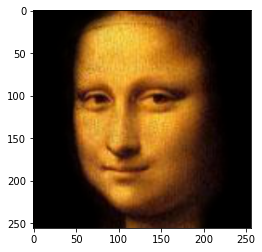

In [66]:
cam_pos = torch.tensor([-0.2697, -5.7891, 373.9277])
cam_look_at = torch.tensor([-0.2697, -5.7891, 54.7918])
img = model(cam_pos, 
            cam_look_at, 
            torch.zeros(199, device = pyredner.get_device()),
            torch.zeros(199, device = pyredner.get_device()),
            torch.ones(3), 
            torch.zeros(3))

imshow(torch.pow(img, 1.0/2.2).cpu())

face_url = 'https://raw.githubusercontent.com/BachiLi/redner/master/tutorials/mona-lisa-cropped-256.png'

urllib.request.urlretrieve(face_url, 'target.png')
target = pyredner.imread('target.png').to(pyredner.get_device())

imshow(torch.pow(target, 1.0/2.2).cpu())

### Задание начальных значений параметров, которые будут восстанавливаться для целевой картины

In [67]:
# Set requires_grad=True since we want to optimize them later
cam_pos = torch.tensor([-0.2697, -5.7891, 373.9277], 
                       requires_grad=True)
cam_look_at = torch.tensor([-0.2697, -5.7891, 54.7918], 
                           requires_grad=True)
shape_coeffs = torch.zeros(199, device = pyredner.get_device(), 
                           requires_grad=True)
color_coeffs = torch.zeros(199, device = pyredner.get_device(), 
                           requires_grad=True)
ambient_color = torch.ones(3, device = pyredner.get_device(), 
                           requires_grad=True)
dir_light_intensity = torch.zeros(3, device = pyredner.get_device(), 
                                  requires_grad=True)

# Use two different optimizers for different learning rates
optimizer = torch.optim.Adam(
                             [
                              shape_coeffs, 
                              color_coeffs, 
                              ambient_color, 
                              dir_light_intensity], 
                             lr=0.1)
cam_optimizer = torch.optim.Adam([cam_pos, cam_look_at], lr=0.5)

### Организация оптимизационного цикла и логирование происходящего с функцией ошибки (попиксельный MSE + квадратичные регуляризаторы параметров) и с самой 3D моделью

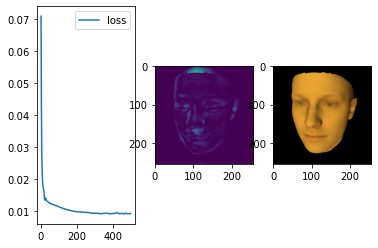

In [68]:
plt.figure()
imgs, losses = [], []

# Run 500 Adam iterations
num_iters = 500
for t in range(num_iters):
    optimizer.zero_grad()
    cam_optimizer.zero_grad()
    img = model(cam_pos, cam_look_at, shape_coeffs, 
                 color_coeffs, ambient_color, dir_light_intensity)
    # Compute the loss function. Here it is L2 plus a regularization 
    # term to avoid coefficients to be too far from zero.
    # Both img and target are in linear color space, 
    # so no gamma correction is needed.

    loss = (img - target).pow(2).mean()
    loss = loss + 0.0001 * shape_coeffs.pow(2).mean() + 0.001 * color_coeffs.pow(2).mean()
    loss.backward()

    optimizer.step()
    cam_optimizer.step()

    ambient_color.data.clamp_(0.0)
    dir_light_intensity.data.clamp_(0.0)

    # Plot the loss
    f, (ax_loss, ax_diff_img, ax_img) = plt.subplots(1, 3)
    losses.append(loss.data.item())

    # Only store images every 10th iterations
    if t % 10 == 0:
        # Record the Gamma corrected image
        imgs.append(torch.pow(img.data, 1.0/2.2).cpu()) 
    clear_output(wait=True)
    ax_loss.plot(range(len(losses)), losses, label='loss')
    ax_loss.legend()
    ax_diff_img.imshow((img -target).pow(2).sum(dim=2).data.cpu())
    ax_img.imshow(torch.pow(img.data.cpu(), 1.0/2.2))
    plt.show()

### Генерация анимации из логов

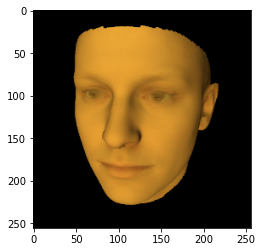

In [69]:
fig = plt.figure()

# Clamp to avoid complains
im = plt.imshow(imgs[0].clamp(0.0, 1.0), animated=True)

def update_fig(i):
    im.set_array(imgs[i].clamp(0.0, 1.0))
    return im,
anim = animation.FuncAnimation(fig, update_fig, 
                               frames=len(imgs), interval=50, blit=True)
HTML(anim.to_jshtml())